<a href="https://colab.research.google.com/github/potofu20061027/Fourier-analysis-of-audio-files/blob/main/%E3%83%95%E3%83%BC%E3%83%AA%E3%82%A8%E7%B4%9A%E6%95%B0%E5%A4%89%E6%8F%9B(%E3%82%B9%E3%83%97%E3%83%AC%E3%83%83%E3%83%89%E3%82%B7%E3%83%BC%E3%83%88%E3%81%8B%E3%82%89).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

近似曲線の次数を入力してください（例: 3）: 5


<ipython-input-1-5b1d5ab184a4>:51: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, degree)


L=3.0

近似曲線 f(x) の関数式:
          5           4           3          2
0.001846 x - 0.01657 x - 0.09121 x + 0.6732 x + 0.4328 x - 4.766e-15


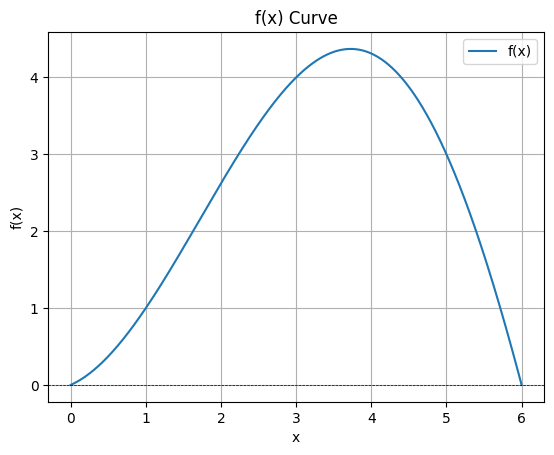


定数 a の値: 2.5466666666666633
スペクトルの最大次数 N を入力してください: 4

スペクトル表 (a(n), b(n)):
n     a(n)            b(n)           
-----------------------------------
1     -1.6998772522   -1.0688233455  
2     -0.3418179630   -0.1006262000  
3     -0.1450774075   -0.0280057482  
4     -0.0802604436   -0.0115477525  


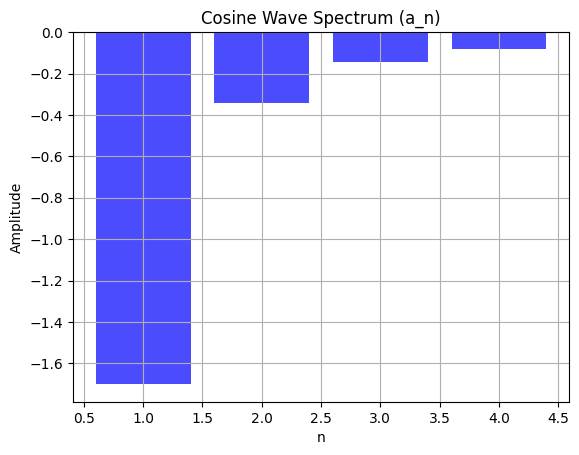

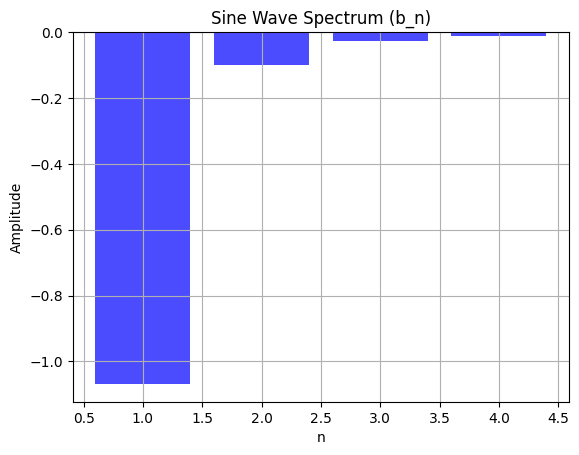

In [1]:
# 必要なライブラリをインストール
!pip install gspread matplotlib numpy scipy oauth2client

from google.colab import auth
from google.auth import default
from google.auth.transport.requests import Request
import gspread
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from oauth2client.client import GoogleCredentials

# Google ColabでGoogleスプレッドシートにアクセスするための設定
def authenticate_google():
    """Authenticates the user and returns a gspread client."""
    creds, _ = default()
    if not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            auth.authenticate_user()
            creds, _ = default()
    client = gspread.authorize(creds)
    return client

# Googleスプレッドシートからデータを取得
def get_google_sheet_data(sheet_url, client):
    sheet = client.open_by_url(sheet_url).sheet1
    data = sheet.get_all_values()
    x_data = []
    y_data = []
    for row in data[1:]:
        try:
            # Try converting the values to float and append them to the lists.
            x = float(row[0])
            y = float(row[1])
            x_data.append(x)
            y_data.append(y)
        except (ValueError, IndexError):
            # If there's an error (e.g., empty cell, non-numeric value),
            # skip the row and print a warning message.
            print(f"Skipping row: {row}. Could not convert to float.")

    # Convert the lists to numpy arrays.
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    return x_data, y_data

# 近似曲線を作成
def create_fitted_curve(x, y, degree=3):
    coeffs = np.polyfit(x, y, degree)
    poly = np.poly1d(coeffs)
    L = (x.max() - x.min()) / 2
    print('L='+str(L))
    return poly, L

# f(x)をプロット
def plot_curve(poly, x_min, x_max):
    x_vals = np.linspace(x_min, x_max, 500)
    y_vals = poly(x_vals)
    plt.plot(x_vals, y_vals, label="f(x)")
    plt.axhline(0, color="black", linewidth=0.5, linestyle="--")
    plt.title("f(x) Curve")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.grid()
    plt.show()

# サンプリング点を事前計算
def precompute_integral(poly, x_min, x_max, num_points=1000):
    x_vals = np.linspace(x_min, x_max, num_points)
    f_vals = poly(x_vals)
    dx = x_vals[1] - x_vals[0]
    return x_vals, f_vals, dx

# 高速スペクトル計算
def calculate_spectra_fast(x_vals, f_vals, dx, L, N):
    a_n = []
    b_n = []
    for n in range(1, N + 1):
        cos_vals = np.cos(n * np.pi * x_vals / L)
        sin_vals = np.sin(n * np.pi * x_vals / L)
        a_n_val = np.sum(f_vals * cos_vals) * dx / L
        b_n_val = np.sum(f_vals * sin_vals) * dx / L
        a_n.append(a_n_val)
        b_n.append(b_n_val)
    return a_n, b_n

# スペクトルのプロット
def plot_spectra(n_range, values, title):
    plt.bar(n_range, values, color="blue", alpha=0.7)
    plt.title(title)
    plt.xlabel("n")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

# スペクトル表の表示
def display_spectra_table(a_n, b_n):
    print("\nスペクトル表 (a(n), b(n)):")
    print(f"{'n':<5} {'a(n)':<15} {'b(n)':<15}")
    print("-" * 35)
    for n, a_val, b_val in zip(range(1, len(a_n) + 1), a_n, b_n):
        print(f"{n:<5} {a_val:<15.10f} {b_val:<15.10f}")

# メイン処理
def main():
    client = authenticate_google()
    sheet_url = "https://docs.google.com/spreadsheets/d/1uEcRCssXHRrlGtGHAn0gDUHFk_oriq5BJ0Dy1sDs7DY/edit#gid=0"

    x, y = get_google_sheet_data(sheet_url, client)

    degree = int(input("近似曲線の次数を入力してください（例: 3）: "))
    poly, L = create_fitted_curve(x, y, degree)

    # f(x)の関数式を表示
    print("\n近似曲線 f(x) の関数式:")
    print(poly)

    plot_curve(poly, x.min(), x.max())

    # aの計算
    a = quad(poly, x.min(), x.max())[0] / (2*L)

    print(f"\n定数 a の値: {a}")

    x_vals, f_vals, dx = precompute_integral(poly, x.min(), x.max())

    N = int(input("スペクトルの最大次数 N を入力してください: "))
    a_n, b_n = calculate_spectra_fast(x_vals, f_vals, dx, L, N)

    # スペクトル表の表示
    display_spectra_table(a_n, b_n)

    n_range = np.arange(1, N + 1)
    plot_spectra(n_range, a_n, "Cosine Wave Spectrum (a_n)")
    plot_spectra(n_range, b_n, "Sine Wave Spectrum (b_n)")

if __name__ == "__main__":
    main()
